In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir("/Users/dhrumilpatel/Documents/mind-speech-interface-ssvep")

In [2]:
from eeg_ai_layer.models.FBCCA import FBCCA
from eeg_ai_layer.models.KNN import KNN
from eeg_ai_layer.models.train import segment_data_from_trials
from eeg_ai_layer.models.utils import split_trials
from eeg_ai_layer.models.ssvep_utils import butter_bandpass_filter
from types import SimpleNamespace
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import trange
sns.set()

In [3]:
args = SimpleNamespace(
    components=1,
    window_length=4,
    sample_rate=250,
    shift_length=1,
    no_zero=True,
    model_type='fbcca_knn',
    model_path='eeg_ai_layer/models/savedmodels/leon.model'
)

knn = KNN(args)

In [80]:
import pandas as pd

offline_path = "eeg_ai_layer/data/leon/296_2022_899506.csv"
online_path = "eeg_ai_layer/data/leon_online/eeg_36.csv"

data = pd.read_csv(online_path)
if "8" in data:
    data.drop(columns=["8"], inplace=True)

In [51]:
# import some data to play with
if 'time' in data and 'Color Code' in data:
    data.drop(columns=['time', 'Color Code'], inplace=True)

# offset 1 for Timestep
if all(data.iloc[0, 1:].values == 0):
    data.at[1, 'Frequency'] = data.loc[0, 'Frequency']
    data = data[1:]
    data.index = np.arange(data.shape[0])

trials = split_trials(data)
segments, segment_labels = segment_data_from_trials(trials=trials, window_length=args.window_length,
                                                    shift_length=args.shift_length,
                                                    sample_rate=args.sample_rate, no_zero=args.no_zero)

In [42]:
trial_freq = [(trial, trial.iloc[0]['Frequency']) for trial in trials]
non_zero_trials = [trial for trial, t in trial_freq if t != 0]
# non_zero_trials = [data[i - 1250:i] for i in range(1250, data.shape[0])]
print(len(non_zero_trials))

40


In [81]:
frequencies = [8.25, 8.75, 9.75, 10.75, 11.75, 12.75, 13.75, 14.25]
colours = ["red", "cyan", "yellow", "green", "blue", "magenta", "black", "white"]
freq2label = {freq: colour for freq, colour in zip(frequencies, colours)}
freq2ax = {freq: idx for idx, freq in enumerate(frequencies)}
freq2label, freq2ax

({8.25: 'red',
  8.75: 'cyan',
  9.75: 'yellow',
  10.75: 'green',
  11.75: 'blue',
  12.75: 'magenta',
  13.75: 'black',
  14.25: 'white'},
 {8.25: 0, 8.75: 1, 9.75: 2, 10.75: 3, 11.75: 4, 12.75: 5, 13.75: 6, 14.25: 7})

100%|████████████████████| 1501/1501 [04:30<00:00,  5.54it/s]


<Figure size 5000x3000 with 0 Axes>

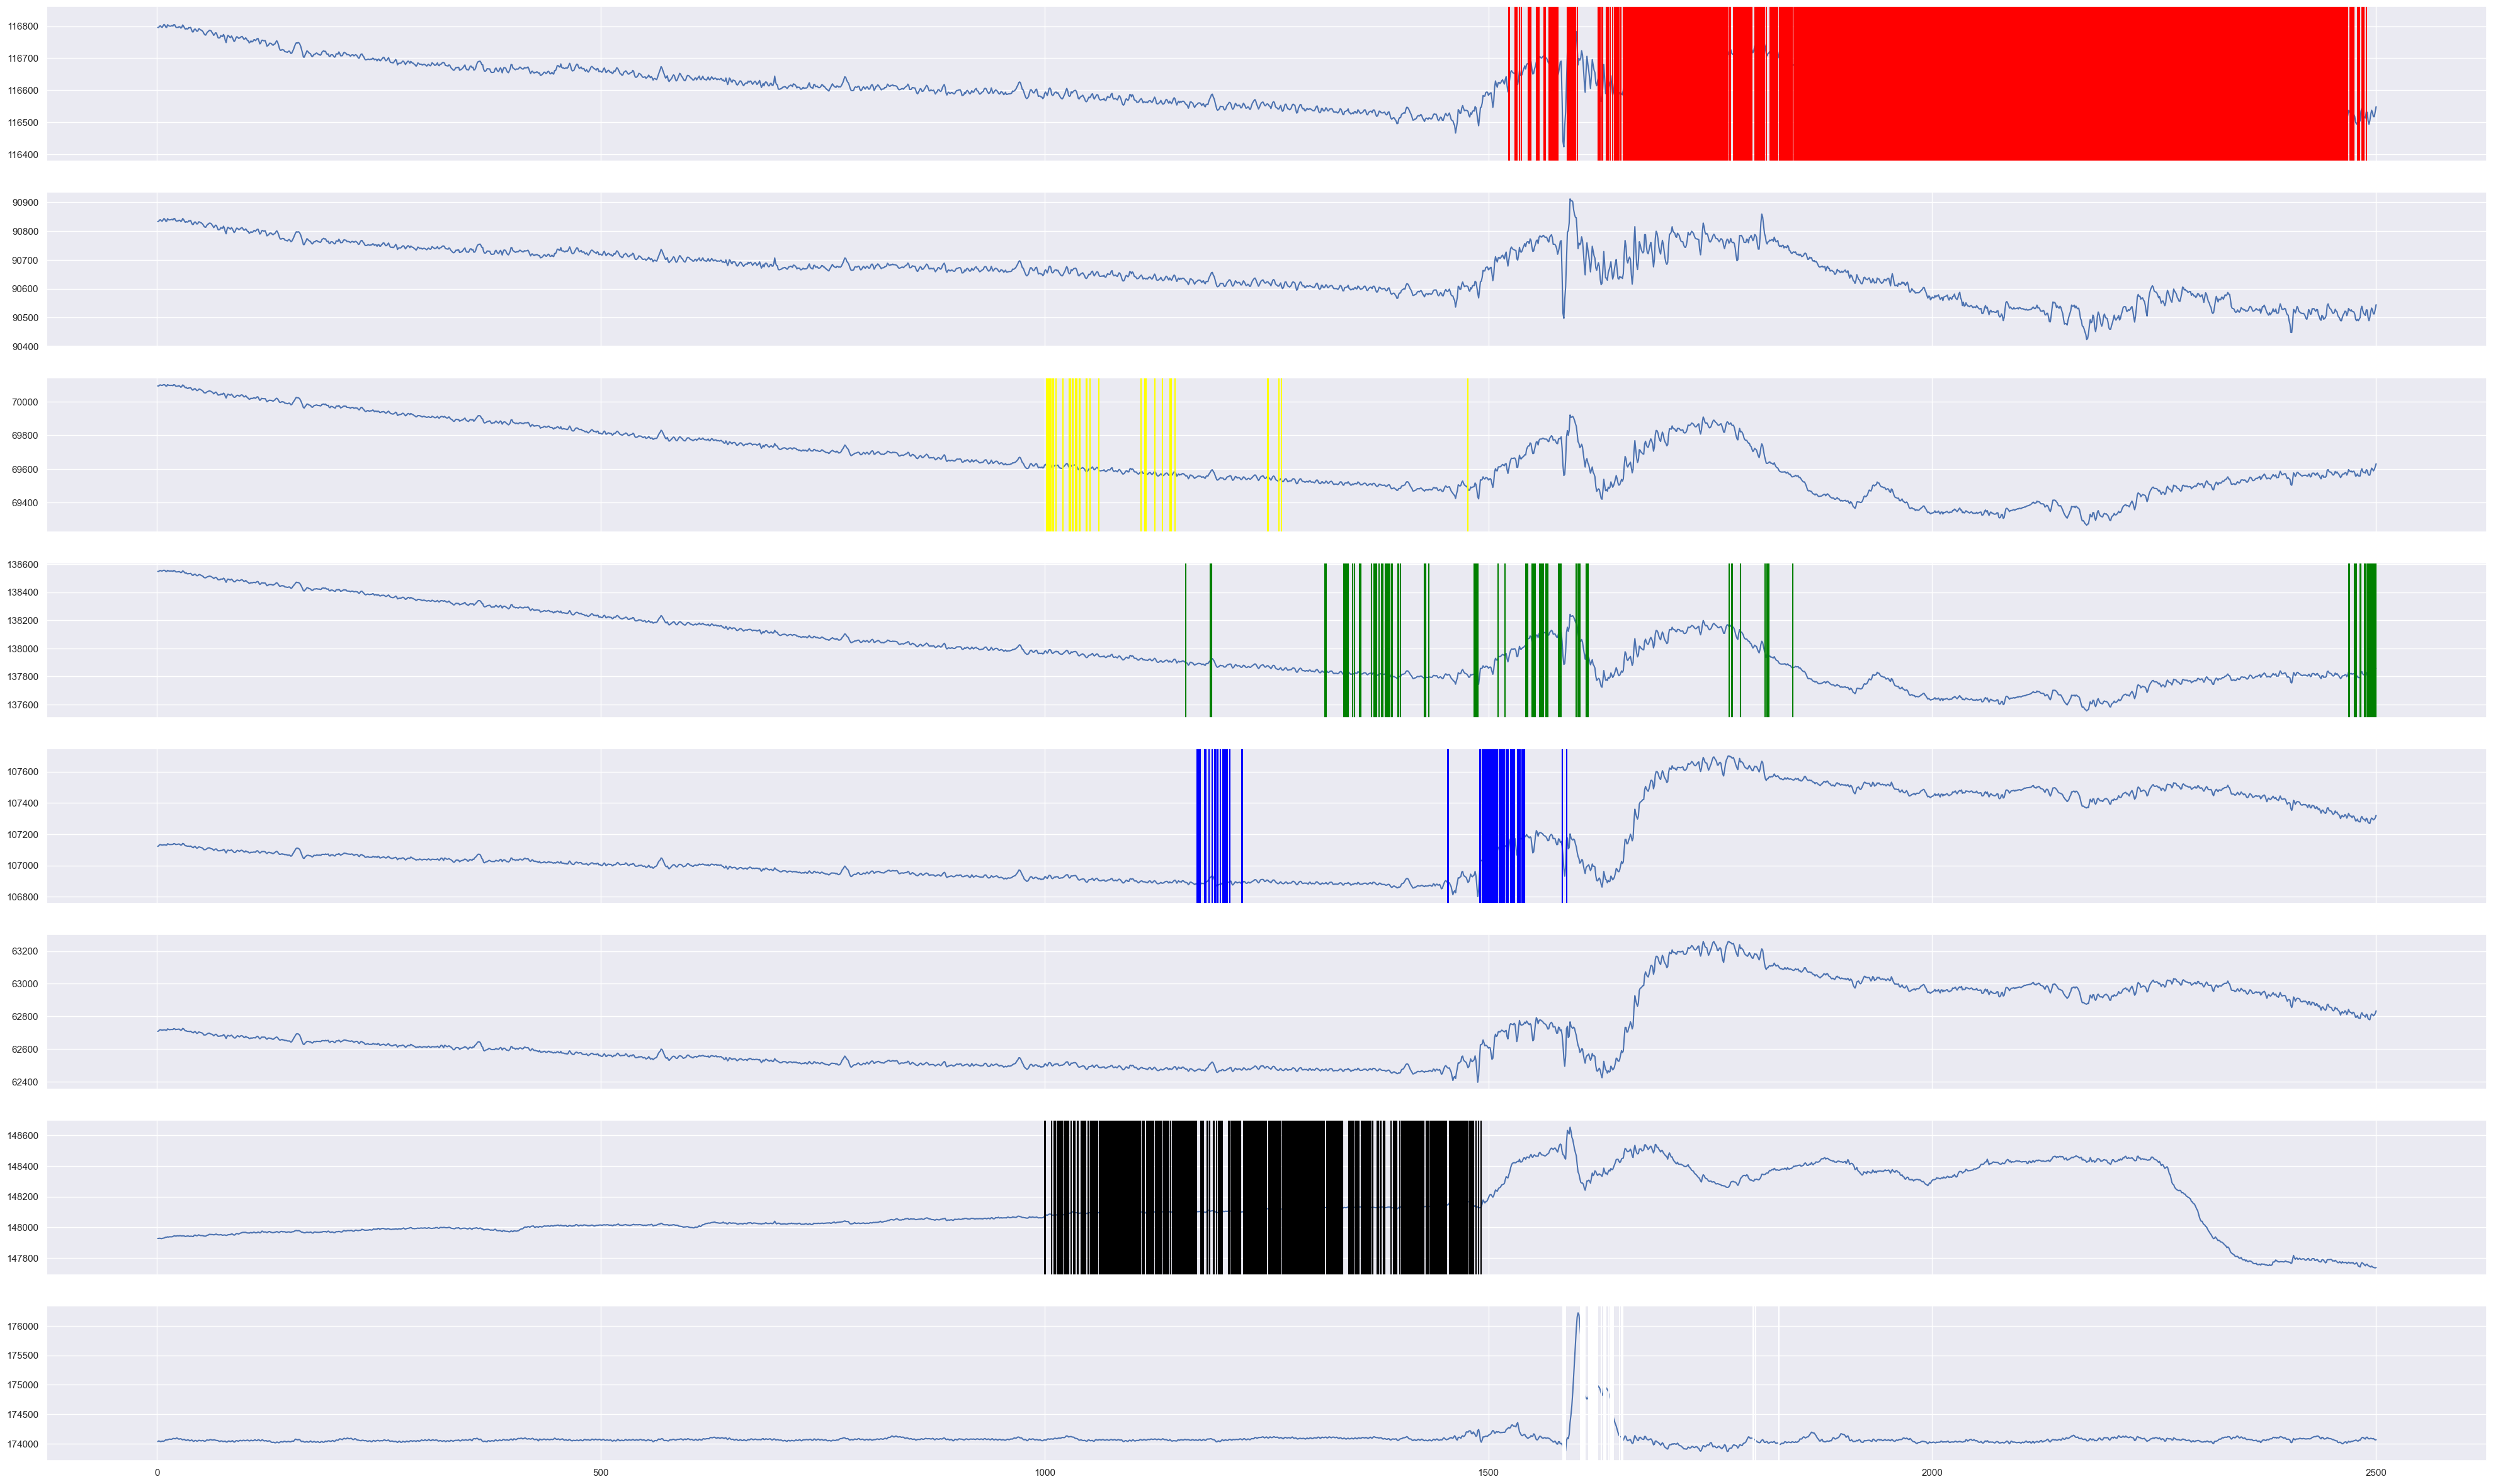

In [89]:
def colour_data(data, duration, channel_data = [str(idx) for idx in range(8)], windowed_predictions = []):
    data.index = np.arange(1, data.shape[0] + 1)
    plt.figure(figsize=(50, 30))
    fig, axes = plt.subplots(8, 1, sharex=True, figsize=(50, 30))
    for idx, ax in enumerate(axes):
        ax.plot(data.loc[:, channel_data[idx]])

    if 'Frequency' in data:
        frequency = data['Frequency']
        data = data.drop(columns=['Frequency'])
        positions = frequency.dropna()
        for pos in positions.index:
            freq = frequency[pos]
            color = 'black'
            if freq != 0:
                color = freq2label[freq]
            for ax in axes:
                ax.axvline(pos, 0, 1, color=color)
    if not windowed_predictions:
        windowed_predictions = []
        samp = np.array(data)
        samp = np.expand_dims(samp, axis=0)
        for end_index in trange(duration, data.shape[0] + 1):
            sample = samp[:, end_index - duration: end_index]
            prepared = knn.prepare(sample)
            prediction, correlations = knn.predict(prepared)
            frequency = knn.convert_index_to_frequency(prediction)
            windowed_predictions.append(frequency[0])
    
    for ei, wp in enumerate(windowed_predictions):
        xf = np.linspace(ei, ei + duration, duration)
        idx = freq2ax[wp]
        small = data.loc[:, channel_data[idx]].min()
        beeg = data.loc[:, channel_data[idx]].max()
#         axes[idx].fill_between(xf, small, beeg, facecolor=freq2label[wp], alpha=0.5)
        axes[idx].axvline(ei + duration, 0, 1, color=freq2label[wp])
    plt.show()
    return windowed_predictions
duration = args.window_length * args.sample_rate

# channel_data = [str(idx) for idx in range(8)]
# channel_data = [f"CH{idx + 1}" for idx in range(8)]
# predicted = colour_data(data[2500:], duration, channel_data)
predicted = colour_data(data[2500:5000], duration)

100%|██████████████████████| 251/251 [00:53<00:00,  4.65it/s]


<Figure size 5000x3000 with 0 Axes>

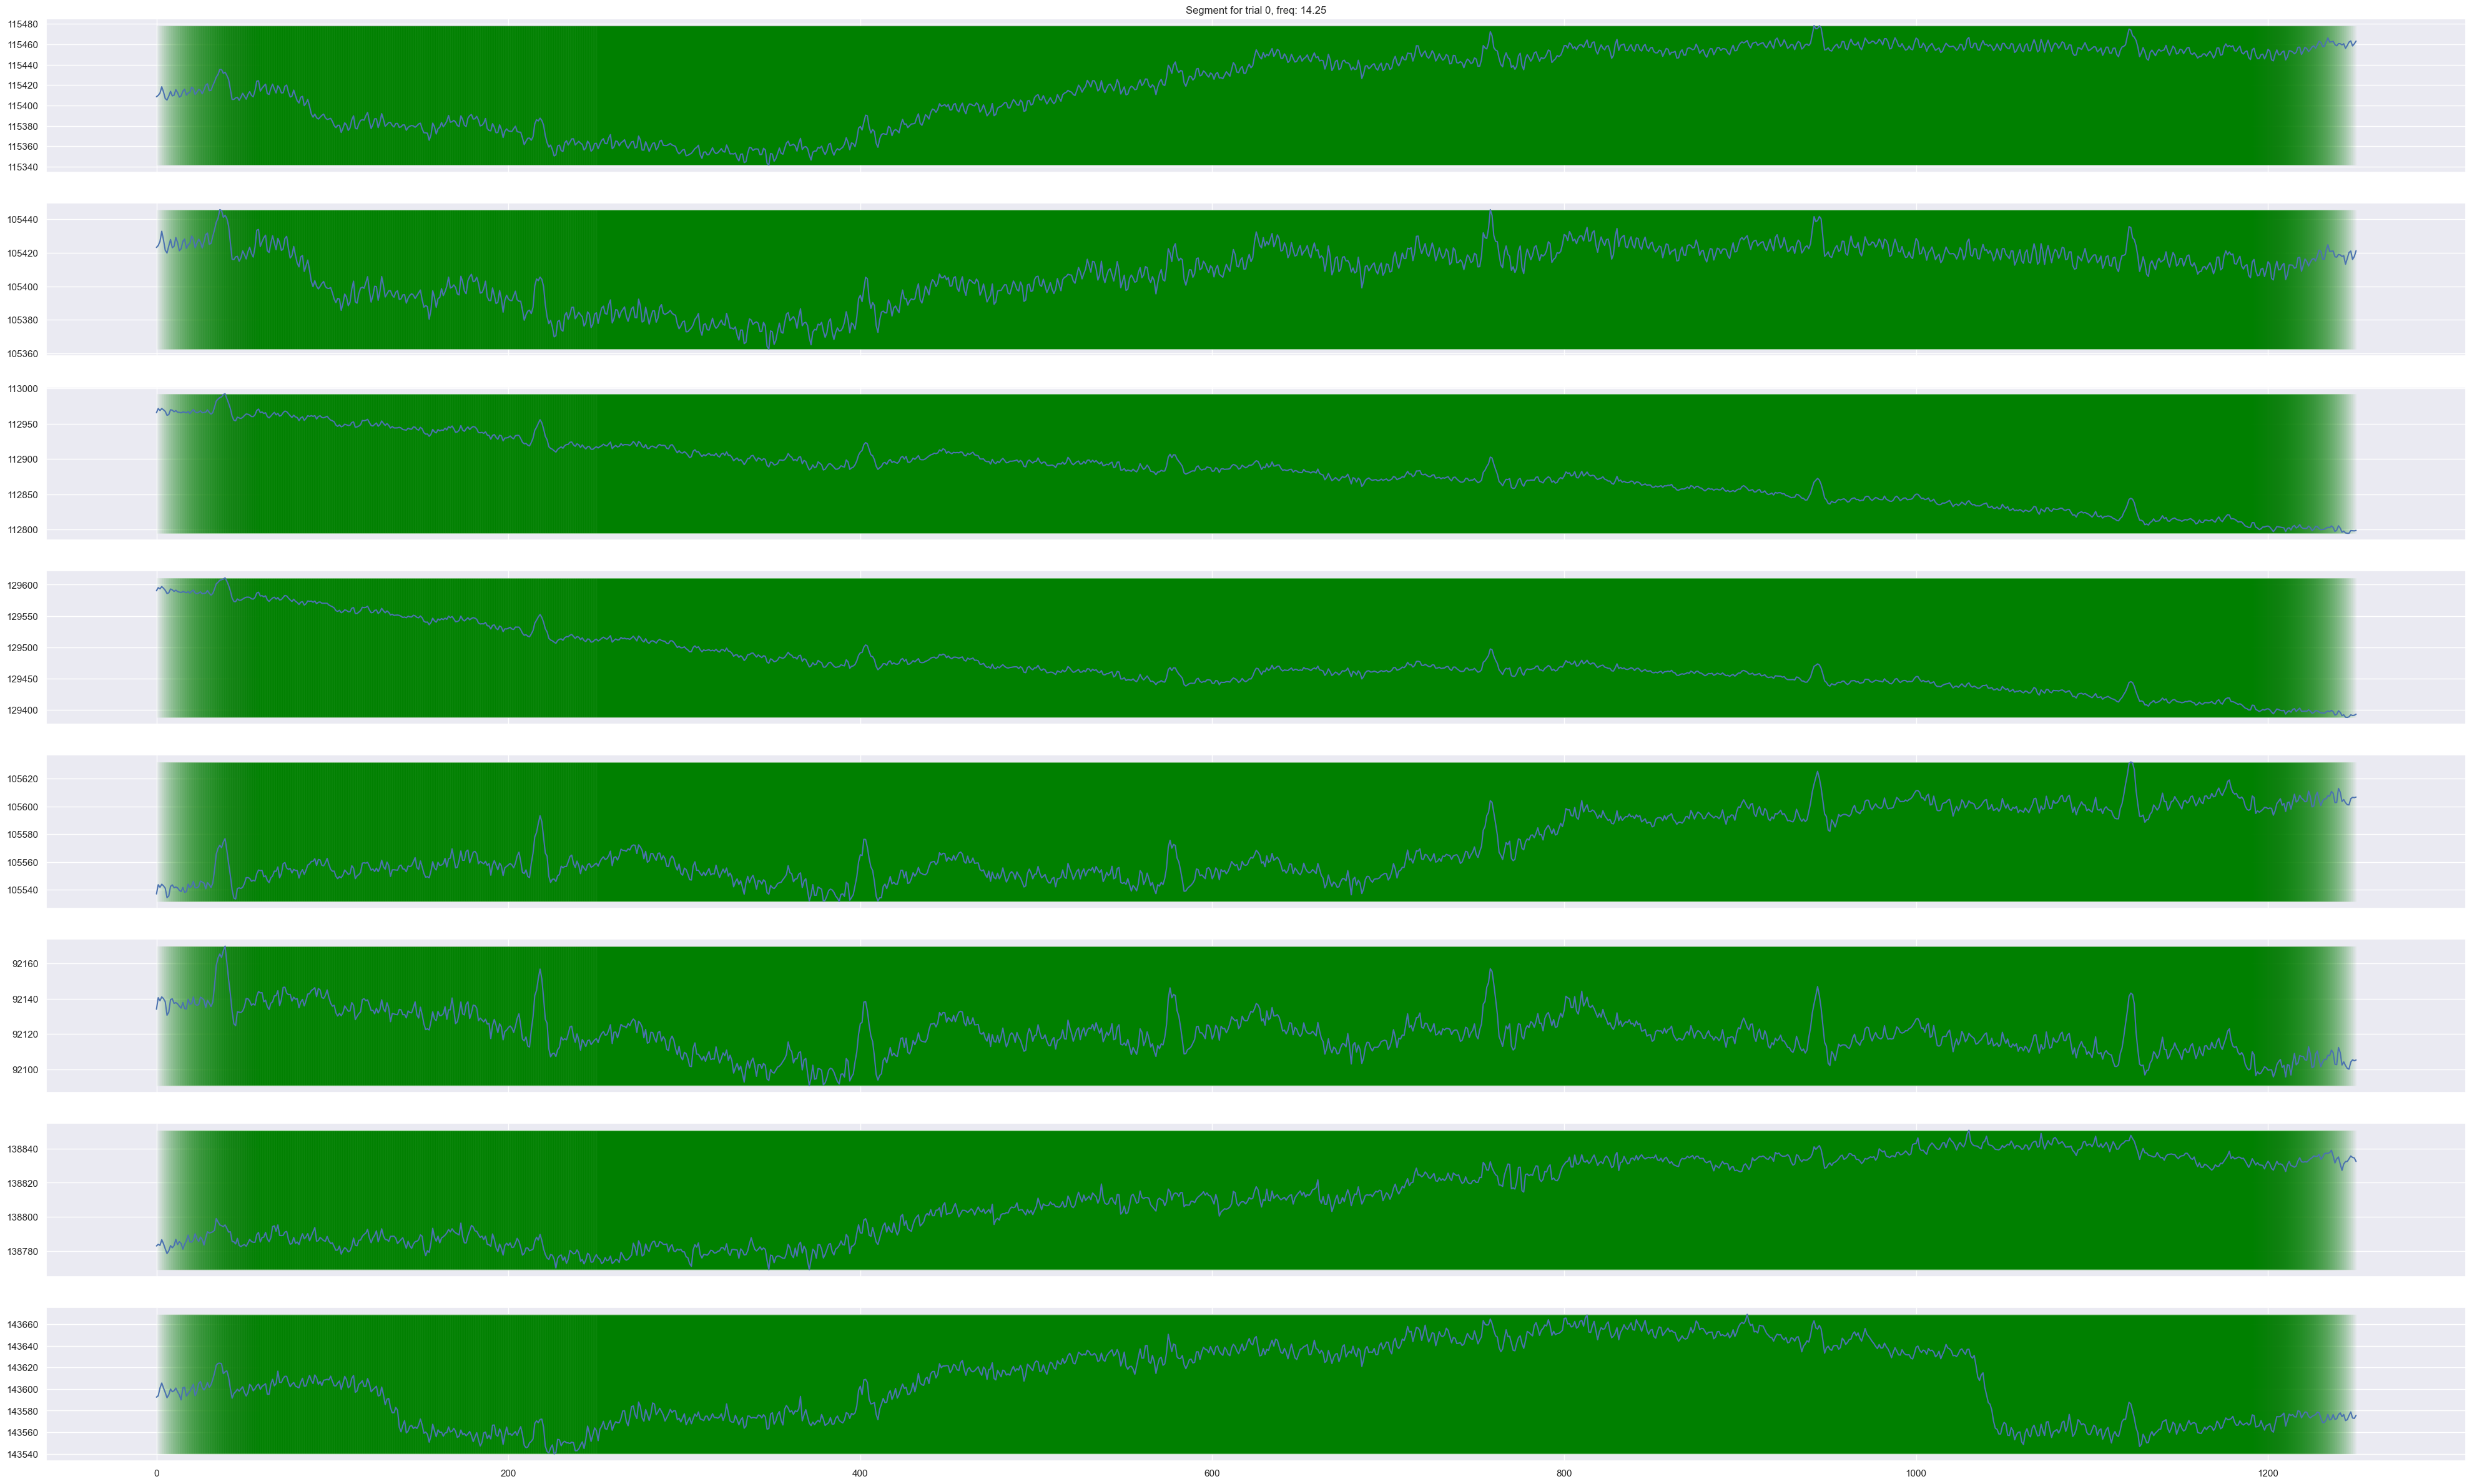

100%|██████████████████████| 252/252 [00:54<00:00,  4.61it/s]


<Figure size 5000x3000 with 0 Axes>

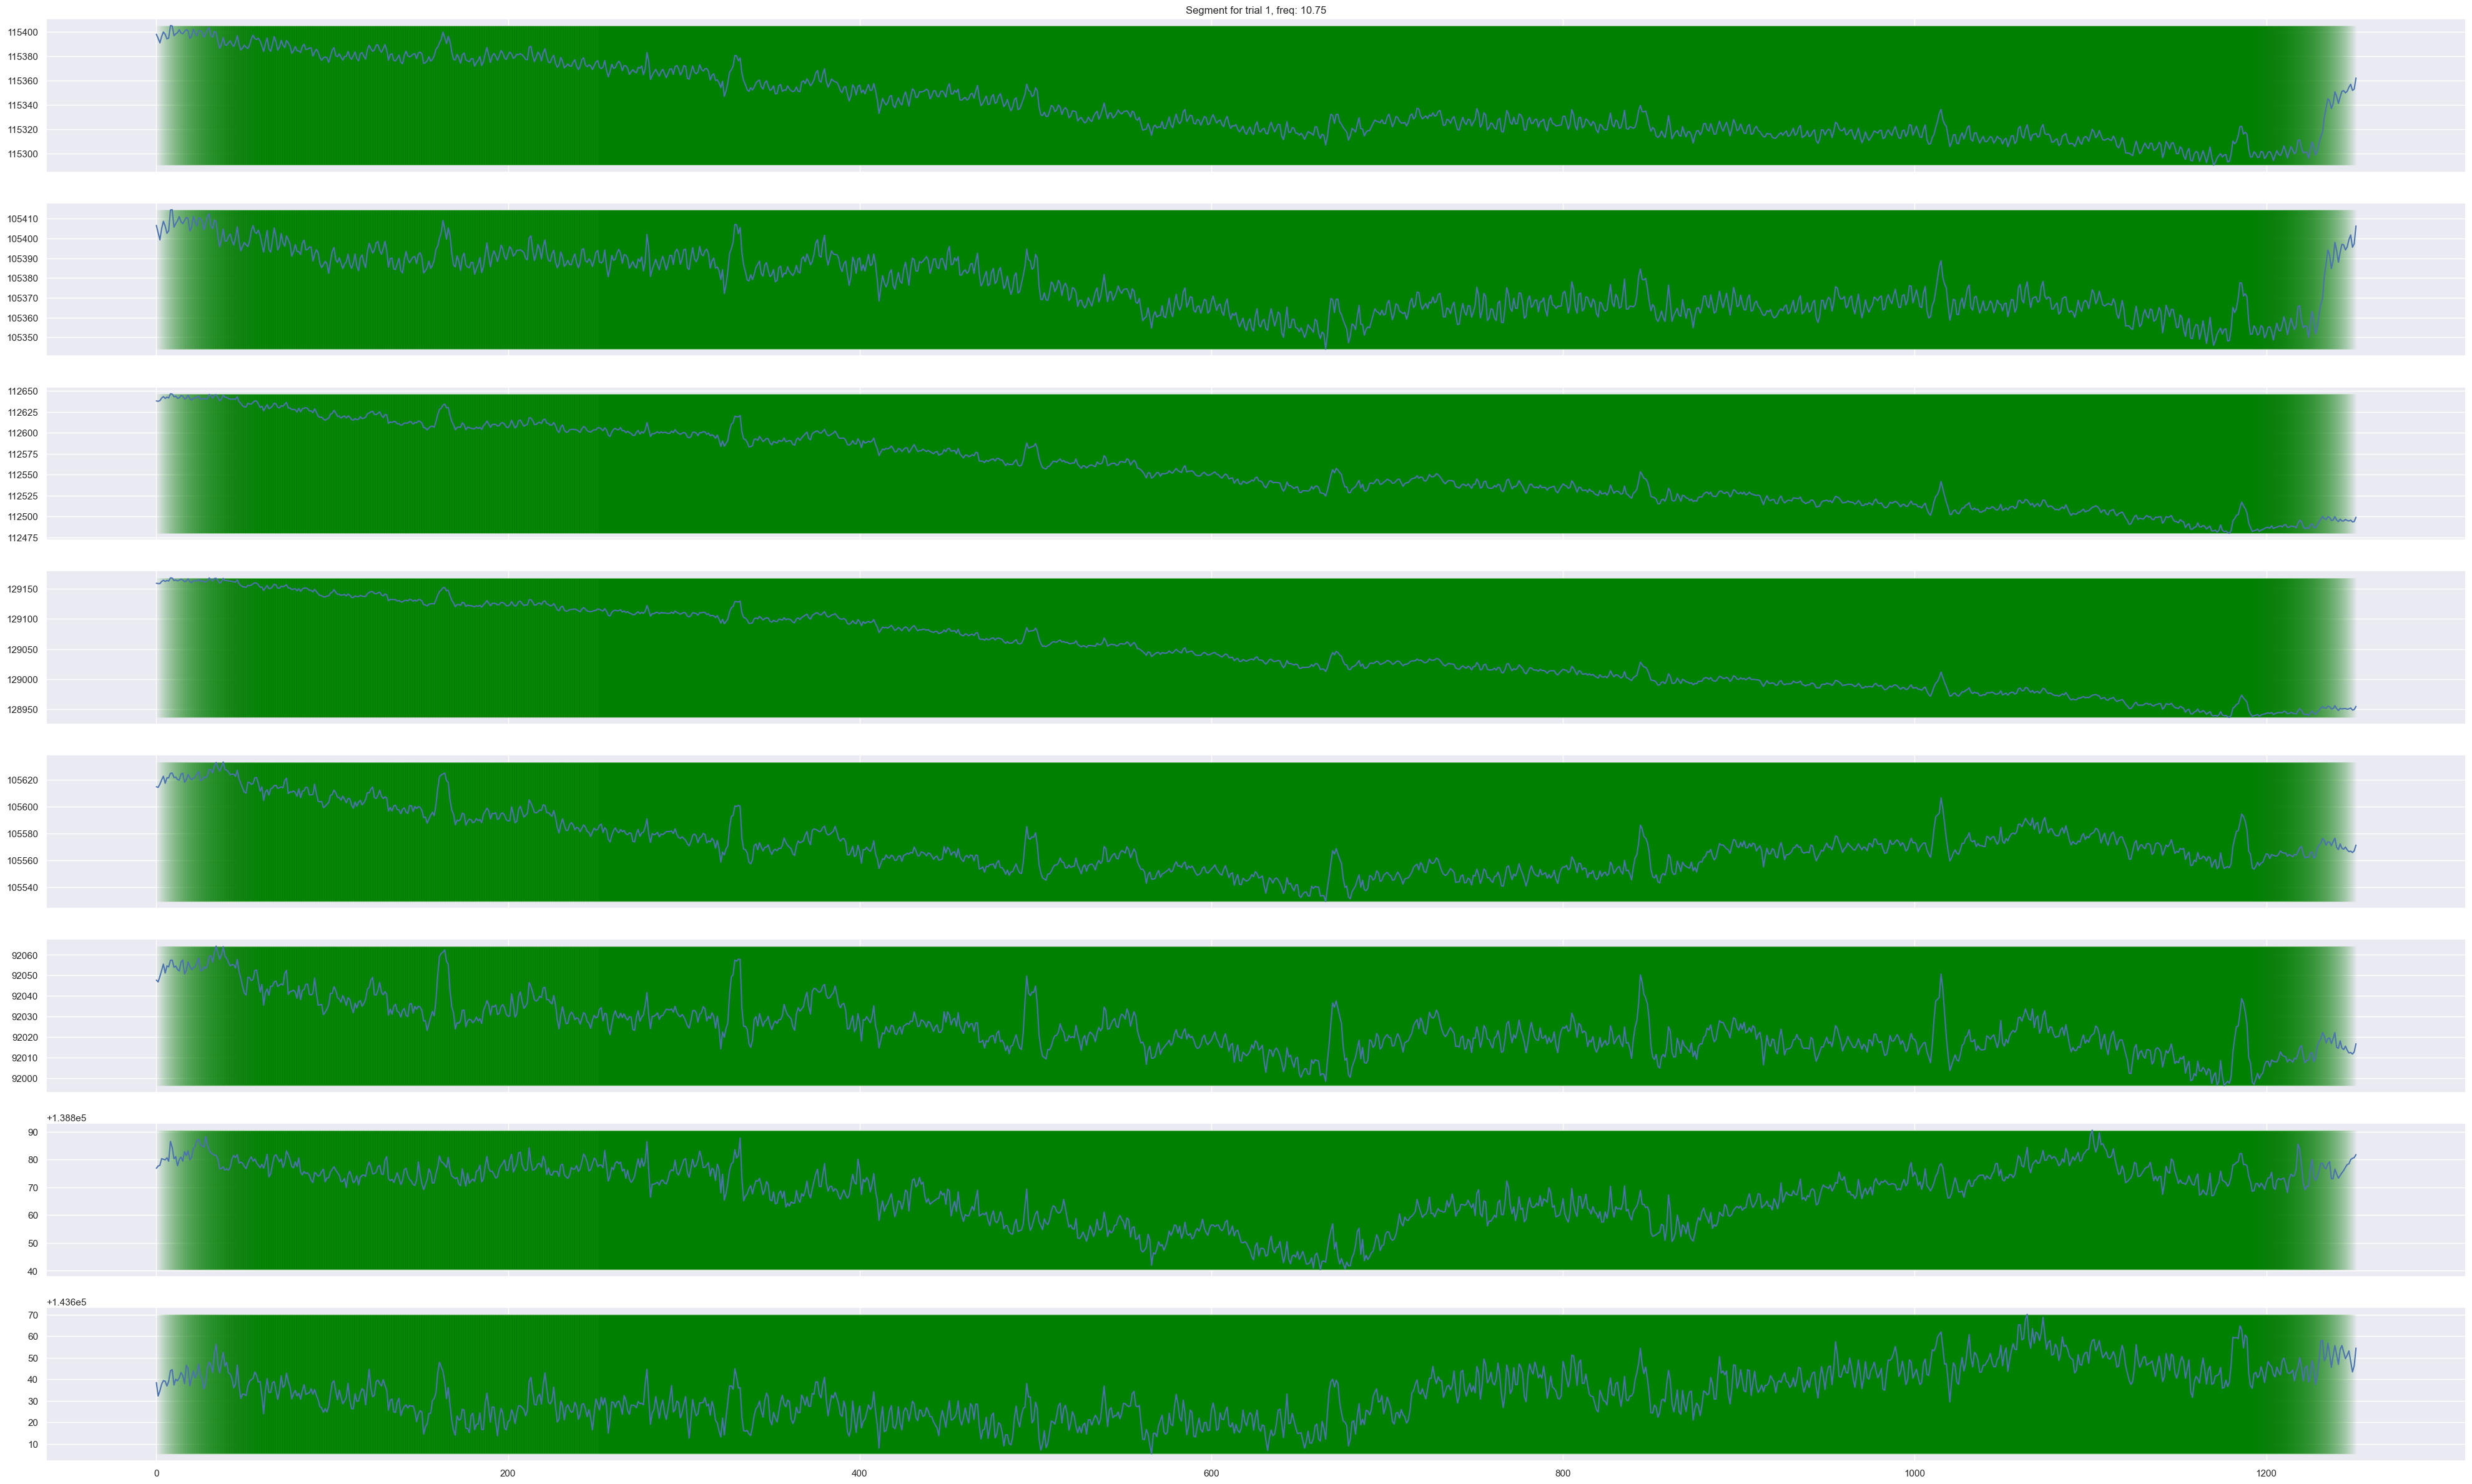

  7%|█▋                     | 19/254 [00:04<00:51,  4.57it/s]


KeyboardInterrupt: 

<Figure size 5000x3000 with 0 Axes>

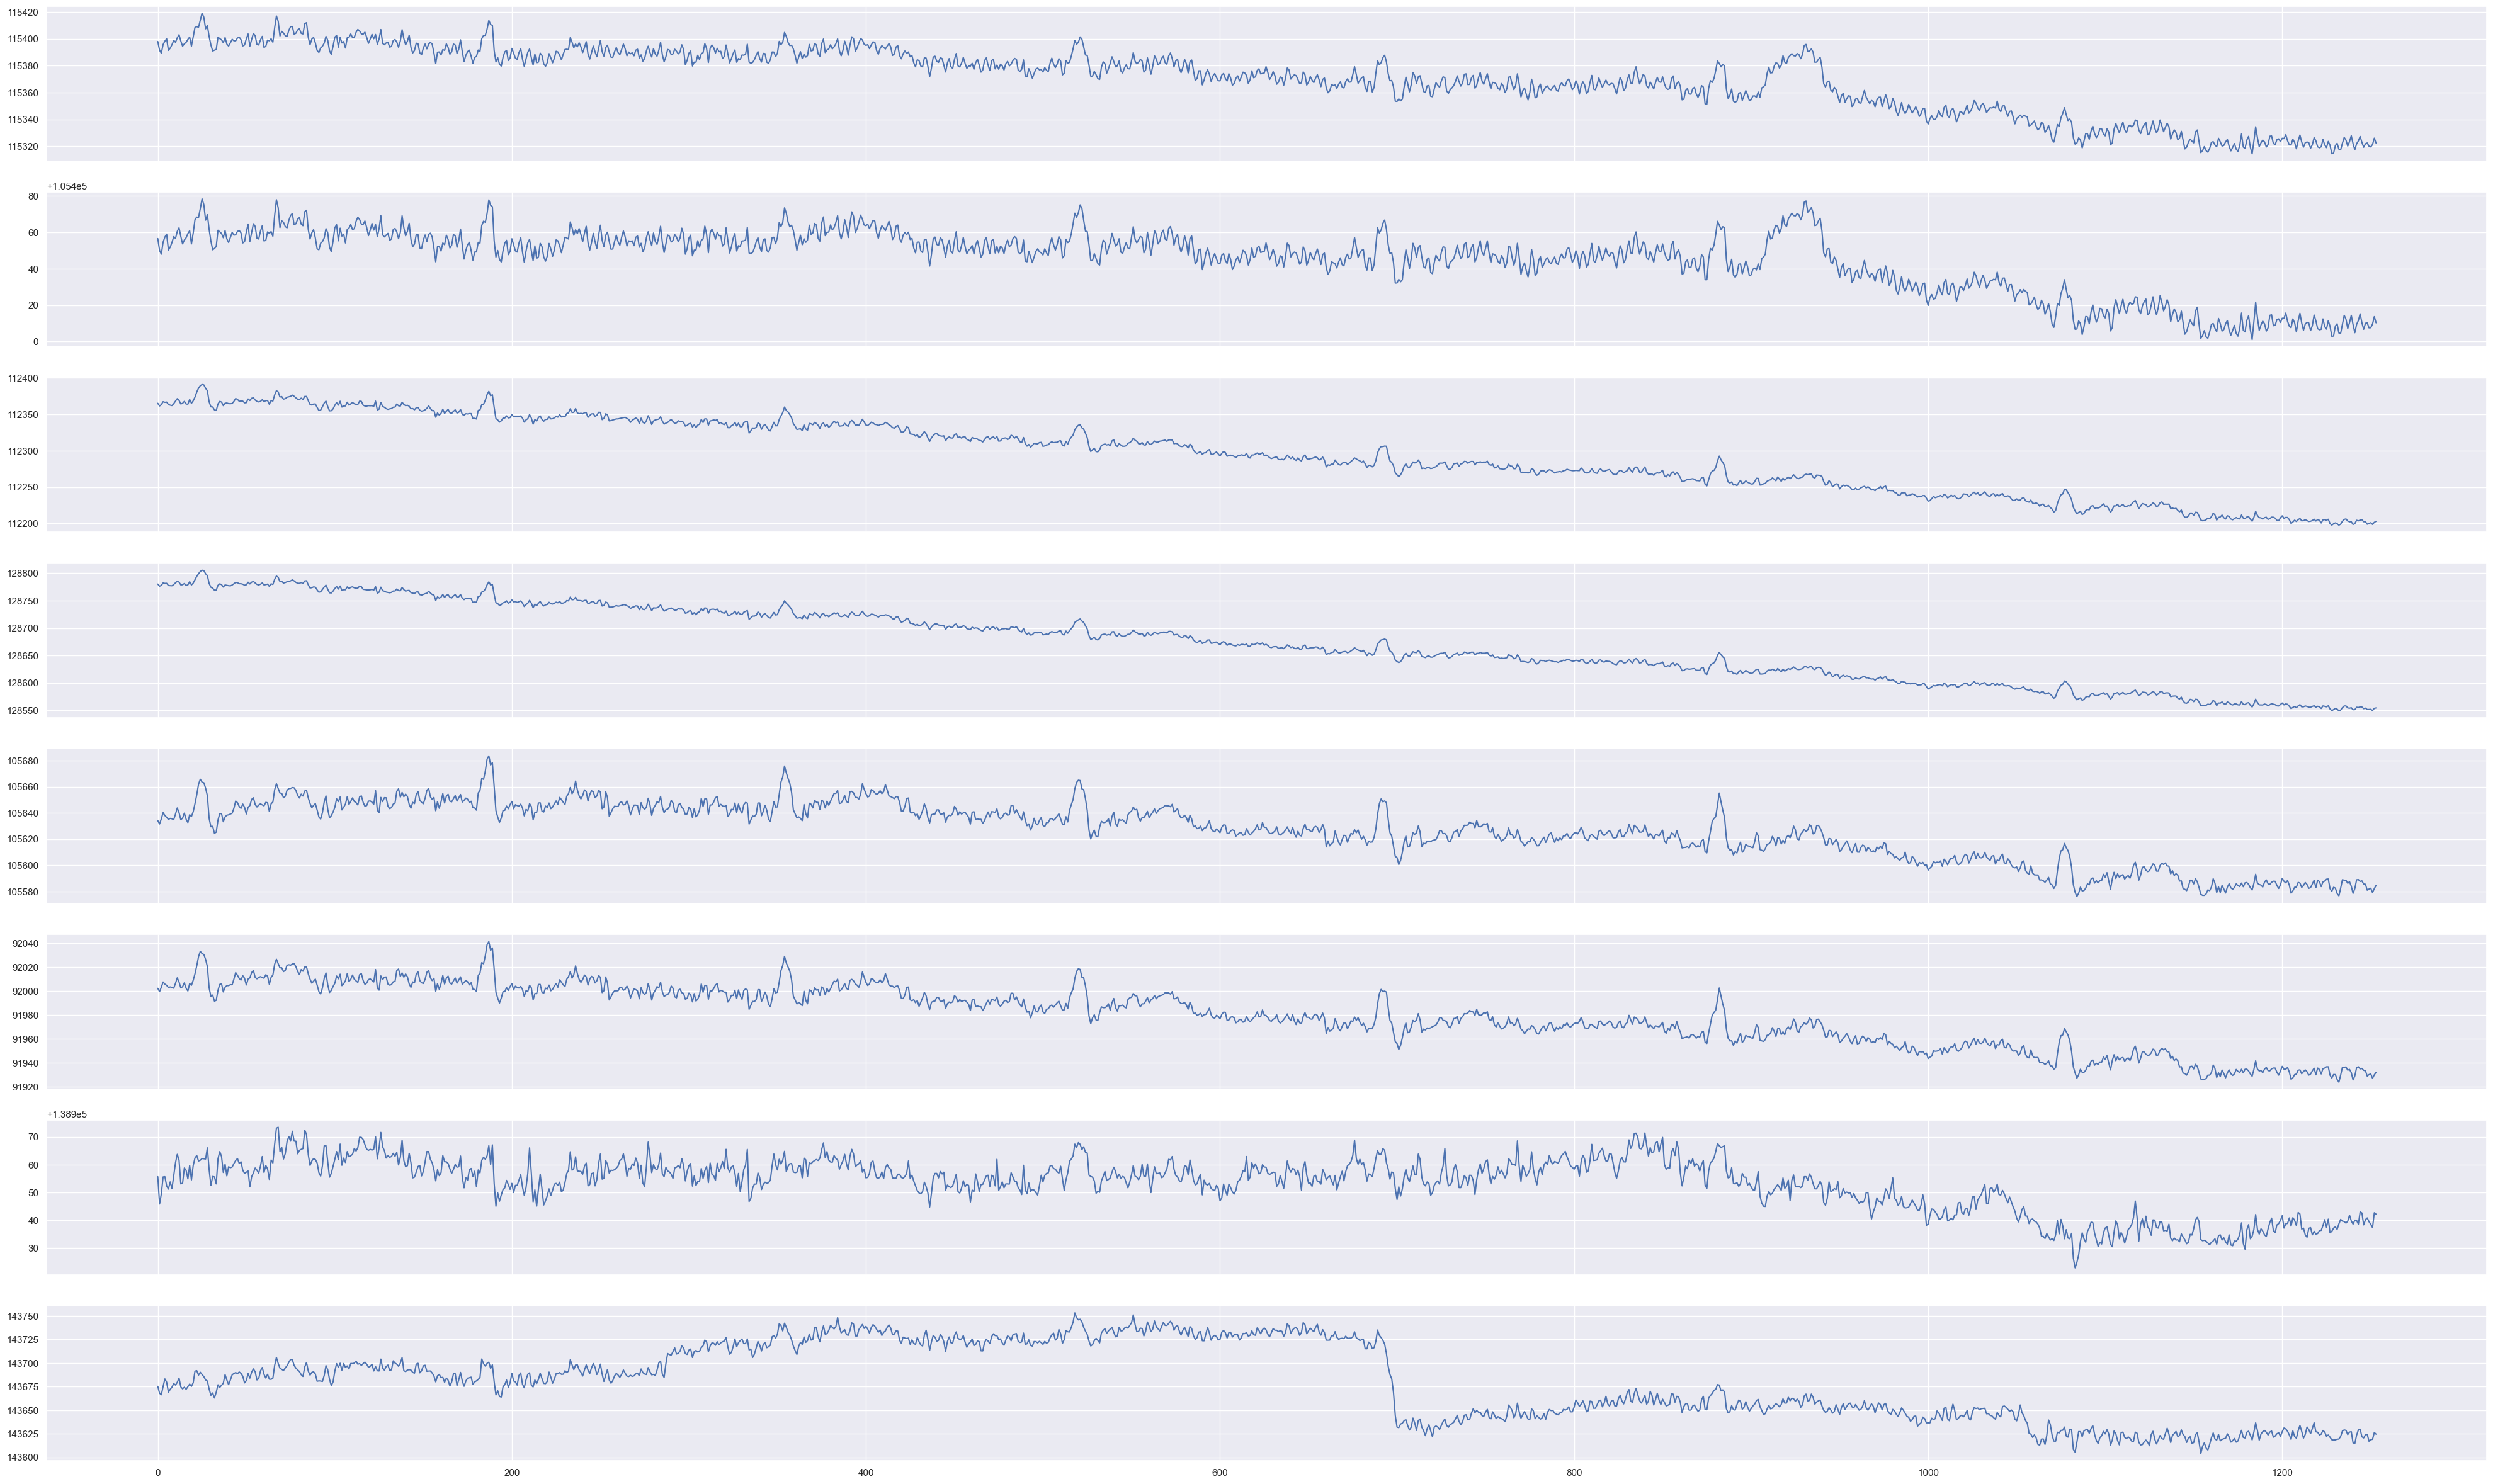

In [44]:
duration = args.window_length * args.sample_rate

def colour_trials(non_zero_trials, channel_data = [str(i) for i in range(8)]):
    for trial_idx in range(len(non_zero_trials)):
        plt.figure(figsize=(50, 30))
        fig, axes = plt.subplots(8, 1, sharex=True, figsize=(50, 30))
        ltrial = non_zero_trials[trial_idx]
        ltrial.index = np.arange(ltrial.shape[0])
        for idx, ax in enumerate(axes):
            ax.plot(ltrial.loc[:, channel_data[idx]])

        ltrial_freq = ltrial.iloc[0]['Frequency']
        windowed_predictions = []

        for end_index in trange(duration, ltrial.shape[0]):
            sample = np.array(ltrial[end_index - duration: end_index])
            sample = sample[:, :-1]
            sample = np.expand_dims(sample, axis=0)
            prepared = knn.prepare(sample)
            prediction, correlations = knn.predict(prepared)
            frequency = knn.convert_index_to_frequency(prediction)
            windowed_predictions.append(frequency[0])

        for ei, wp in enumerate(windowed_predictions):
            xf = np.linspace(ei, ei + duration, duration)
            fc = 'green'
            if wp != ltrial_freq:
                fc = 'red'
            for idx, ax in enumerate(axes):
                small = ltrial.loc[:, f"CH{idx + 1}"].min()
                beeg = ltrial.loc[:, f"CH{idx + 1}"].max()
                ax.fill_between(xf, small, beeg, facecolor=fc, alpha=0.05)
        axes[0].set_title(f"Segment for trial {trial_idx}, freq: {ltrial_freq}")
        plt.show()
colour_trials(non_zero_trials, [f"CH{idx}" for idx in range(1, 9)])